# 1.TOPIC

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#import pandas_datareader as web
import datetime as dt
#import seaborn as sns



In [2]:
data_path = '/home/nghia/Work/code/DBM301/Assigment/data/kobe_weather_2015-2021.csv'
df = pd.read_csv(data_path, index_col="Date")
df.index = pd.to_datetime(df.index)
df.head(5)

,Temparature
Date,
2015-01-01,2.4
2015-01-02,2.4
2015-01-03,4.0
2015-01-04,6.9
2015-01-05,9.0


## Data info


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2015-01-01 to 2021-10-09
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temparature  2474 non-null   float64
dtypes: float64(1)
memory usage: 38.7 KB


In [4]:
df.describe()

,Temparature
count,2474.000000
mean,17.613298
std,7.986805
min,-0.800000
25%,10.300000
50%,18.200000
75%,24.400000
max,32.400000


## Clean data

- Remove redundant columns
- Remove duplicates
- Handle missing values
- Convert data types to the correct data type

In [5]:
# Drop Unamed col
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Drop duplicated!
df = df.dropna(axis='columns',how='all')

In [6]:
def fill_nan_cell(df):
    for col in df.columns:
        df[col].fillna((df[col].mean()), inplace=True)
    return df

In [7]:
df = fill_nan_cell(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2015-01-01 to 2021-10-09
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temparature  2474 non-null   float64
dtypes: float64(1)
memory usage: 38.7 KB


## Visualization

<Axes: title={'center': 'Temparature'}, xlabel='Date'>

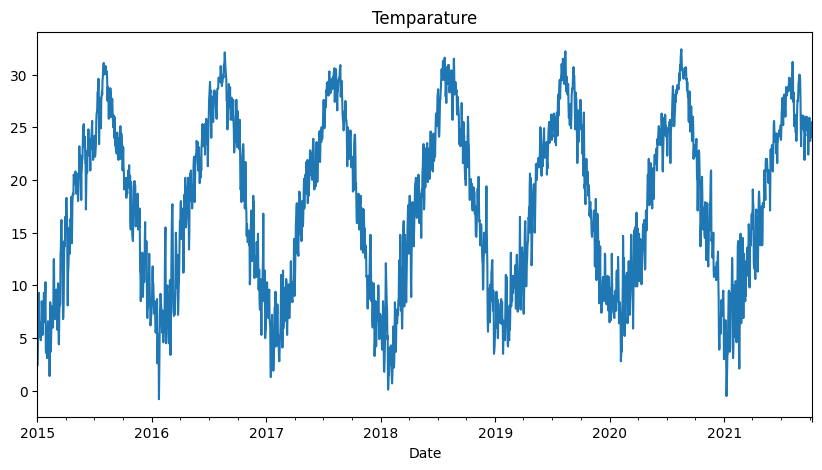

In [9]:
df["Temparature"].plot(figsize=(10,5), title="Temparature")


## Standarlize

In [10]:
df["Temparature_std"] =( df["Temparature"] - df['Temparature'].mean() ) / df["Temparature"].std()

<Axes: xlabel='Date'>

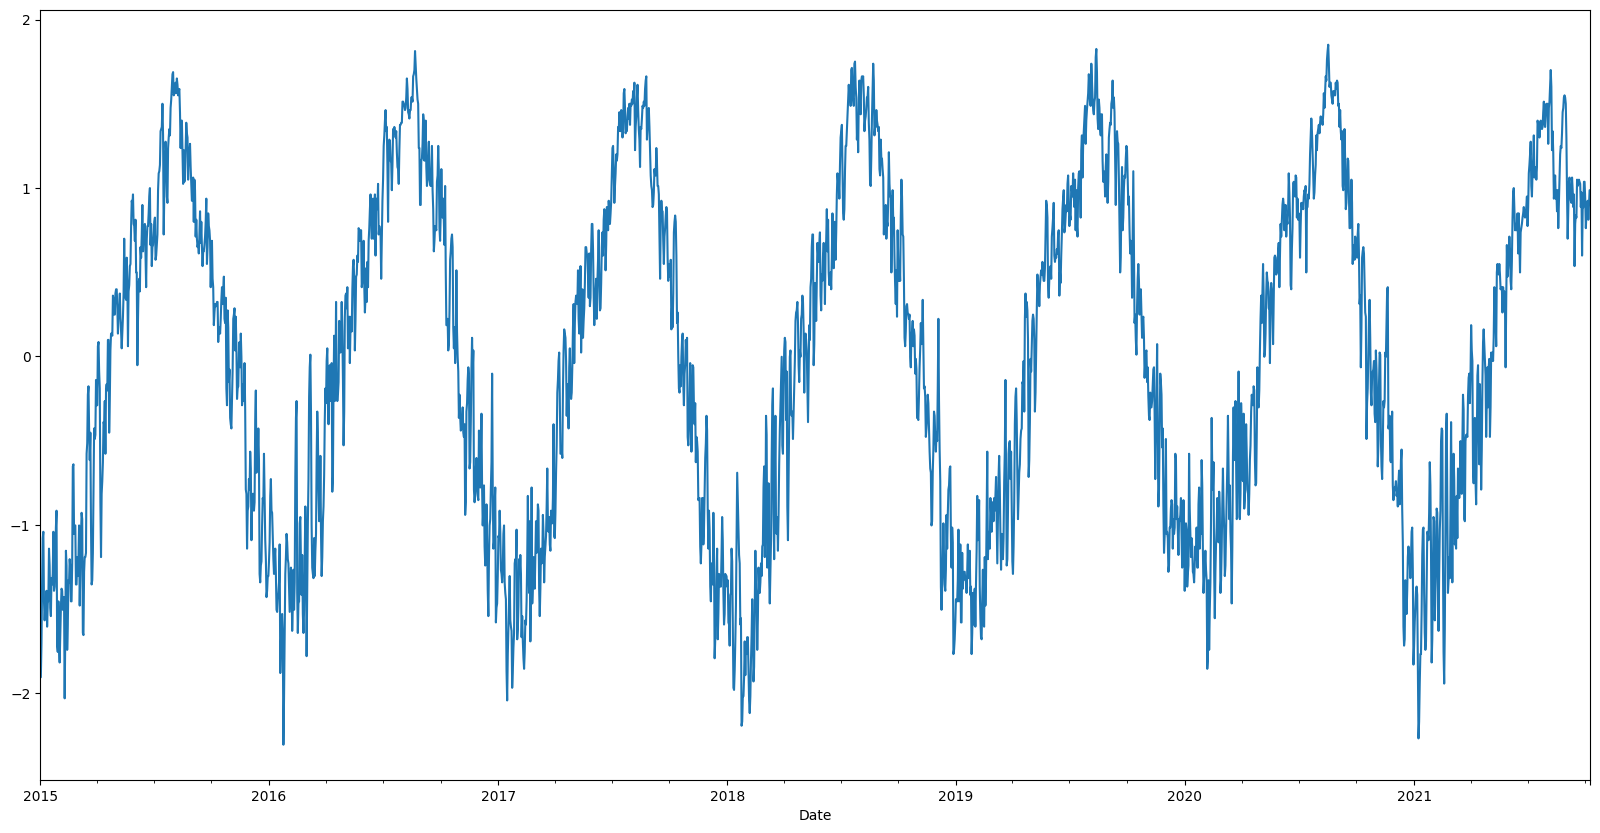

In [11]:
df["Temparature_std"].plot(figsize=(20,10))

## Wavelet Transform



<img src="/home/nghia/Work/code/DBM301/Assigment/illustration/The_Wavelet_Transform_for_Beginners.gif" style="width:1000px;height:700px;">

Reference:
- https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/ 
- https://youtu.be/jnxqHcObNK4 
- https://youtu.be/eJLF9HeZA8I 

The wavelet transforms the data can be truncated and this is helpful in data reduction. If we store a small fraction of the strongest wavelet coefficients then the compressed approximation of the original data can be obtained. 

In [12]:
import pywt
signal = df["Temparature_std"].values.squeeze()
time = df.index.to_numpy()


In [13]:
print(signal.shape)

(2474,)


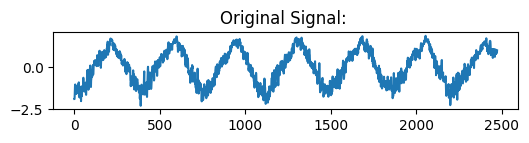

(1241,) (1241,)
(625,) (625,)
(317,) (317,)
(163,) (163,)
(86,) (86,)


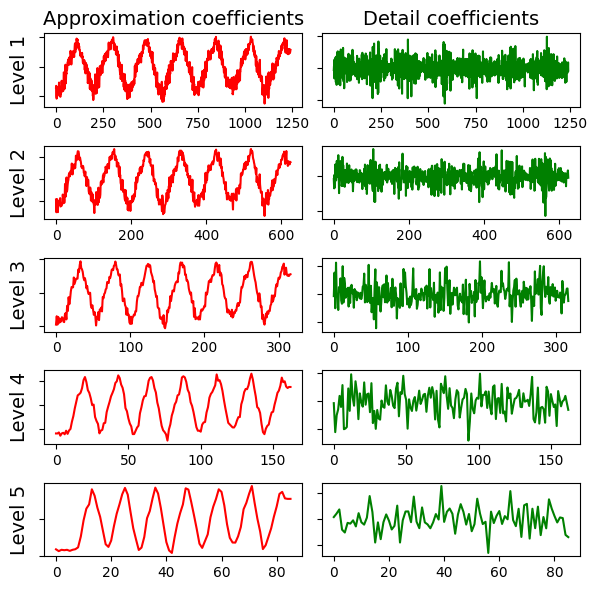

In [14]:

fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(signal)
plt.show()
    
data = signal
waveletname = 'db5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    print(data.shape,coeff_d.shape)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

- The DWT return two sets of coefficients; the approximation coefficients and detail coefficients.
- The approximation coefficients represent the output of the low pass filter (averaging filter) of the DWT.
- The detail coefficients represent the output of the high pass filter (difference filter) of the DWT.

Length of coefficients arrays depends on the selected mode. For all modes except periodization:

len(cA) == len(cD) == floor((len(data) + wavelet.dec_len - 1) / 2)

For periodization mode (“per”):

len(cA) == len(cD) == ceil(len(data) / 2)

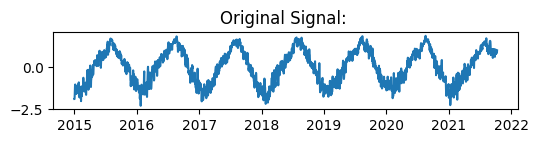

(2518,)


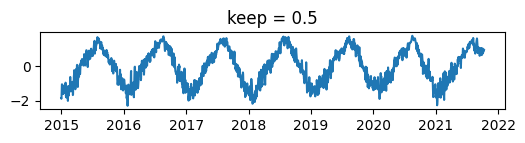

1259


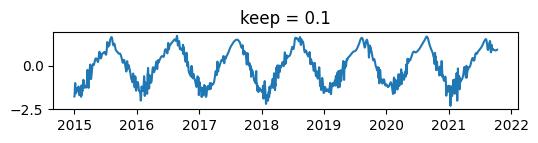

2266


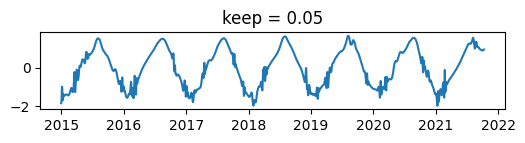

2392


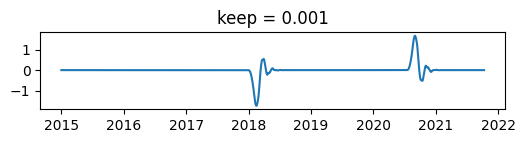

2515


In [15]:
## wavelet Compression
level= 5
waveletname = "db5"

#show original
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(time,signal)
plt.show()


coeffs = pywt.wavedec(signal, waveletname, level=level)
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
print(Csort.shape)

for keep in (0.5, 0.1, 0.05, 0.001):
    #find desire threshold point 
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    cfilt = coeff_arr * ind

    coeffs_filt = pywt.array_to_coeffs(cfilt,coeff_slices, output_format='wavedec')

    #plot reconstruction
    compress = pywt.waverec(coeffs_filt,wavelet=waveletname)
    plt.figure(figsize=(6,1))
    plt.plot(time,compress)
    plt.title("keep = " + str(keep))
    plt.show()

    print(int(np.floor((1-keep)*len(Csort))))



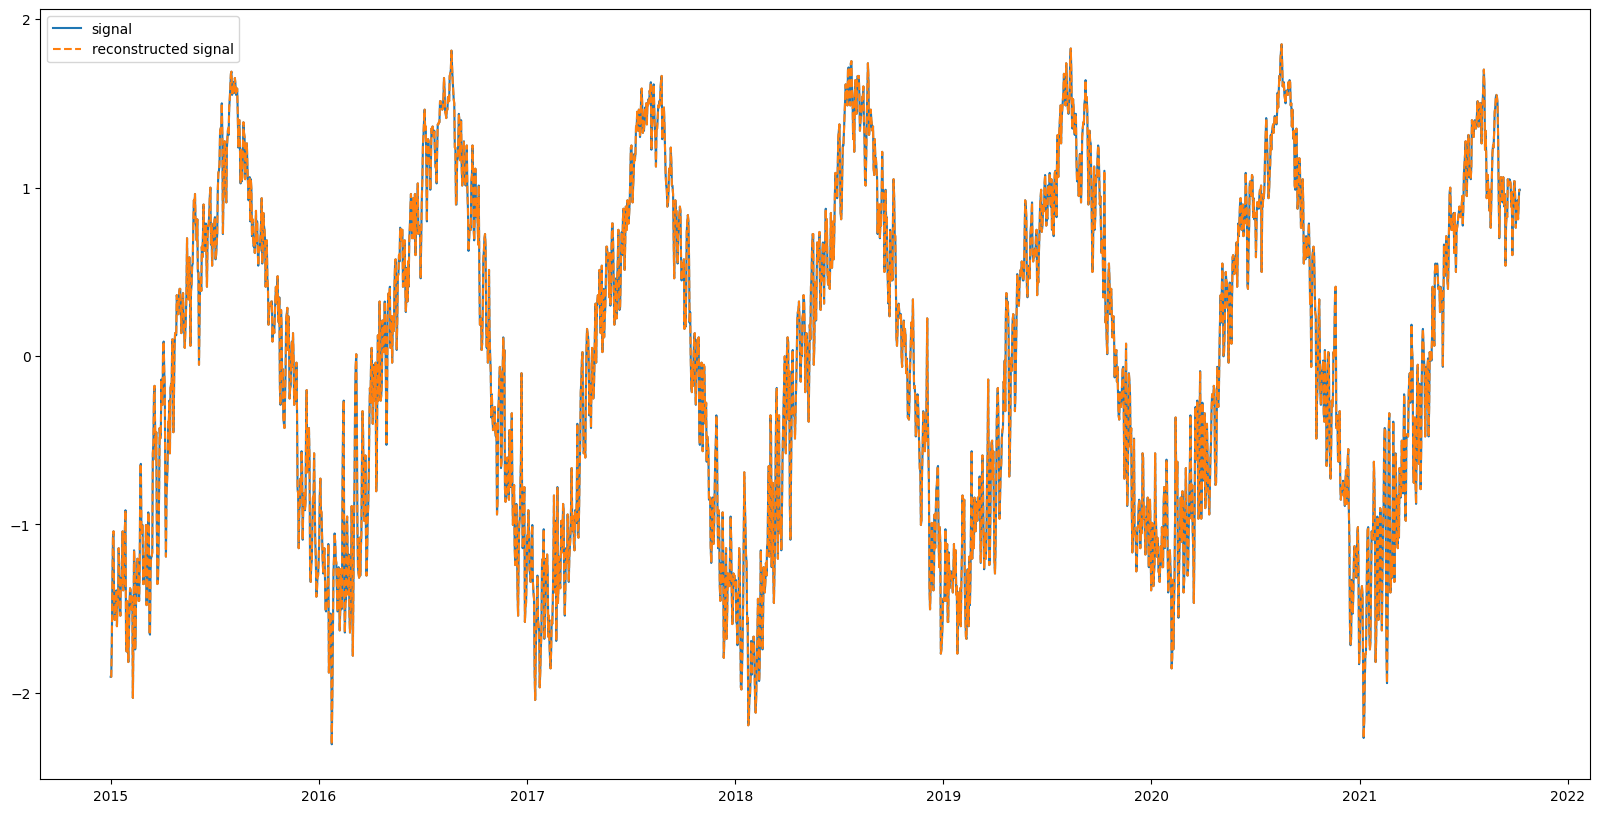

In [16]:

(cA1, cD1) = pywt.dwt(signal, 'db2')
reconstructed_signal = pywt.idwt(cA1, cD1, 'db2', 'smooth')
 
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(time,signal, label='signal')
ax.plot(time,reconstructed_signal, label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
plt.show()